# Fama-French Portfolio Sorts


_The way to become rich is to put all your eggs in one basket and then watch that basket_ - Andrew Carnegie

Concepts:
- Fama-French research factors
- Bivariate portfolio sorts
- Linear Regression
- Structural Break

References:
- Eugene F. Fama and Kenneth R. French (1992), "The Cross-Section of Expected Stock Returns", Journal of Finance, Volume 47, Issue 2, June 1992, pages 427-465
- Eugene Fama and Kenneth French (2023), "Production of U.S. Rm-Rf, SMB,
  and HML in the Fama-French Data Library", Chicago Booth Paper No. 23-22
- FRM Exam I Book Quantative Analysis Chapter 7-8

In [1]:
import numpy as np
import scipy
from scipy.stats import skew, kurtosis
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from finds.database import SQL, RedisDB
from finds.structured import BusDay, CRSP, CRSPBuffer, Signals, Benchmarks, PSTAT
from finds.utils import plot_date
from finds.backtesting import bivariate_sorts, BackTest
from finds.utils import plot_date, plot_scatter, plot_hist
from tqdm import tqdm
from secret import credentials, CRSP_DATE

In [2]:
VERBOSE = 0
# %matplotlib qt

In [3]:
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
pstat = PSTAT(sql, bd, verbose=VERBOSE)
signals = Signals(user, verbose=VERBOSE)
bench = Benchmarks(sql, bd, verbose=VERBOSE)
backtest = BackTest(user, bench, rf='RF', max_date=CRSP_DATE, verbose=VERBOSE)
LAST_DATE = bd.endmo(CRSP_DATE, -1)  # last monthly rebalance date

## Stock fundemntals

### Compustat

Compustat is a database of financial statements and other market information on active and inactive US and international companies, which is commonly used by academic and industry researchers.

Calculate book-to-price ratios from financial statements:

- load items from Compustat Annual
- Construct HML as shareholders equity plus investment tax credits, 
   less preferred stock, divided by December market cap.
- Require 6 month reporting lag and at least two years history in Compustat
- Do not add Deferred Taxes and Investment Tax Credit to BE for
  fiscal years ending in 1993 or later (FASB 109, which was issued in 1993,
  improves the accounting for deferred income taxes)


In [4]:
label = 'hml'
lag = 6               # number of months to lag fundamental data
# retrieve data fields from compustat, linked by permno
df = pstat.get_linked(dataset = 'annual',
                      date_field = 'datadate',
                      fields = ['seq', 'pstk', 'pstkrv', 'pstkl', 'txditc'],
                      where = ("indfmt = 'INDL'"
                               "  AND datafmt = 'STD'"
                               "  AND curcd = 'USD' "
                               "  AND popsrc = 'D'"
                               "  AND consol = 'C'"
                               "  AND seq > 0 "))

In [5]:
# subtract preferred stock
df[label] = np.where(df['pstkrv'].isna(), df['pstkl'], df['pstkrv'])
df[label] = np.where(df[label].isna(), df['pstk'], df[label])
df[label] = np.where(df[label].isna(), 0, df[label])

In [6]:
# do not add back deferred investment tax credit for fiscal years in 1993 or later
df[label] = (df['seq'] - df[label]
             + df['txditc'].fillna(0).where(df['datadate'] // 10000 <= 1993, 0))
df.dropna(subset = [label], inplace=True)
df = df[df[label] > 0][['permno', 'gvkey', 'datadate', label]]

In [7]:
# count years in Compustat        
df = df.sort_values(by=['gvkey','datadate'])
df['count'] = df.groupby(['gvkey']).cumcount()   

In [8]:
# construct b/m ratio
df['rebaldate'] = 0
for datadate in tqdm(sorted(df['datadate'].unique())):
    f = df['datadate'].eq(datadate)
    rebaldate = bd.endmo(datadate, abs(lag)) # 6 month lag
    capdate = bd.endyr(datadate)   # Dec mktcap
    if rebaldate >= CRSP_DATE or capdate >= CRSP_DATE:
        continue
    df.loc[f, 'rebaldate'] = rebaldate
    df.loc[f, 'cap'] = crsp.get_cap(capdate, use_permco=True)\
                           .reindex(df.loc[f, 'permno'])\
                           .values
df[label] /= df['cap']
df = df[df[label].gt(0) & df['count'].gt(1)]  # 2+ years in Compustat
signals.write(df, label)

100%|██████████| 747/747 [00:02<00:00, 290.07it/s]


223346

## Bivariate sorts

Independent bivariate sorts create portfolios sorted by the two variables: book-to-price ratio and market capitalization size. The portfolios, which are constructed at the end of each June, are the intersections of 2 portfolios formed on size (market equity, ME) and 3 portfolios formed on the ratio of book equity to market equity (BE/ME). The size breakpoint for year t is the median NYSE market equity at the end of June of year t. Stocks are market cap-weighted within each of the 6 portfolios.

HML (High Minus Low) is the equal-weighted average return on the two value portfolios minus the average return on the two growth portfolios. SMB (Small Minus Big) is the equal-weighted average return on the three small portfolios minus the average return on the three big portfolios.

__Casual Analysis__

This sorting procedure can be motivated by the field of casual analysis, where a submodel of propensity scores is often used to reduce the influence of confounding variables by creating groups with similar probabilities of receiving a treatment. Propensity scores are typically calculated using statistical methods such as logistic regression to predict the probability of receiving the treatment. Once propensity scores are obtained, researchers can use them in different ways:
- Stratification: Grouping subjects into strata based on propensity scores and analyzing each stratum separately.
- Matching: Pairing treated and control subjects with similar propensity scores.
- Regression Adjustment: Including the propensity score as a covariate in regression models to adjust for imbalances in baseline characteristics.

Note that the values of company size variable directly enters into the calculation of book-to-market ratio (as its denominator). Just as propensity score analysis helps to mitigate the effects of confounding variables and improve the validity of causal inference in observational studies, the matching provided by bivariate sorting can more accurately estimate the returns to the Value outcome while controlling for any Small Firm effect.



### HML

Compute High Minus Low book-to-price monthly returns and compare to Fama-French research factor

In [9]:
label, benchname = 'hml', 'HML(mo)'
rebalend = LAST_DATE
rebalbeg = 19700101

In [10]:
# preload monthly dataset into memory
monthly = CRSPBuffer(stocks=crsp, dataset='monthly',
                     fields=['ret', 'retx', 'prc'],
                     beg=19251201, end=CRSP_DATE)

In [11]:
hml, smb = bivariate_sorts(stocks=monthly,
                           label=label,
                           signals=signals,
                           rebalbeg=rebalbeg,
                           rebalend=rebalend,
                           window=12,
                           months=[6])

Helpers to show histograms and comparisons of portfolio returns


In [12]:
def plot_ff(y, label):
    """helper to scatter plot and compare portfolio returns"""
    y = y.rename(columns={'excess': label})
    corr = np.corrcoef(y, rowvar=False)[0,1]
    fig, (ax1, ax2) = plt.subplots(2, 1, clear=True, figsize=(10, 10))
    plot_date(y, ax=ax1, title=" vs ".join(y.columns), fontsize=7)
    plot_scatter(y.iloc[:,0], y.iloc[:,1], ax=ax2, abline=False, fontsize=7)
    plt.legend([f"corr={corr:.4f}"], fontsize=8)
    plt.tight_layout(pad=0.5)
    print(f"<R-squared of {label} vs {benchname}"
          f" ({y.index[0]} - {y.index[-1]}): {corr*corr:.4f}")

In [13]:
def plot_summary(y, label):
    """helper to plot histogram and statistics of portfolio returns"""
    y = y[label]
    kurt = kurtosis(y, bias=True, fisher=True)  # excess kurtosis
    skewness = skew(y, bias=True)
    fig, ax = plt.subplots(1, 1, clear=True, figsize=(10, 5))
    ax.hist(y, bins=30)
    ax.set_title(f"Monthly rebalances ({y.index[0]}-{y.index[-1]})")
    ax.set_xlabel(f"skewness={skewness:.4f}, excess kurtosis={kurt:.4f}",
                  fontsize=8)
    plt.legend([label])
    plt.tight_layout()

<R-squared of hml vs HML(mo) (19700227 - 20231130): 0.9786


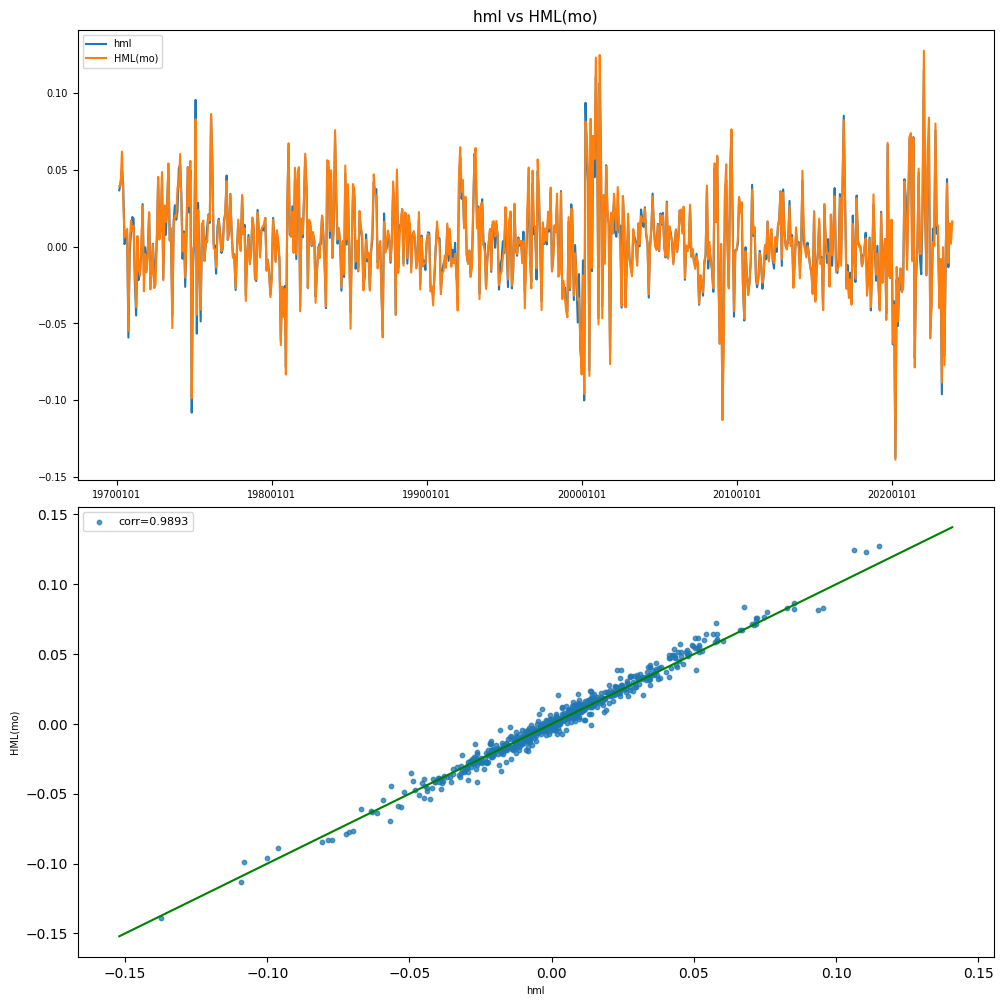

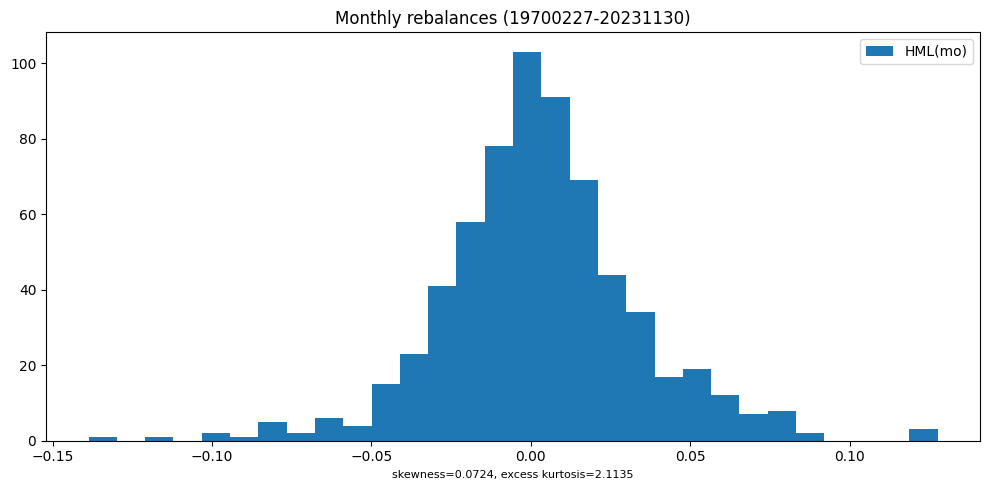

In [14]:
# Plot histogram and comparison of HML returns
holdings = hml
result = backtest(monthly, holdings, label)
y = backtest.fit([benchname], rebalbeg, LAST_DATE)
plot_ff(y, label)
plot_summary(y, benchname)

### SMB

Compare Small-Minus-Big monthly returns and compare to Fama-French research factor

<R-squared of smb vs SMB(mo) (19700227 - 20231130): 0.9652


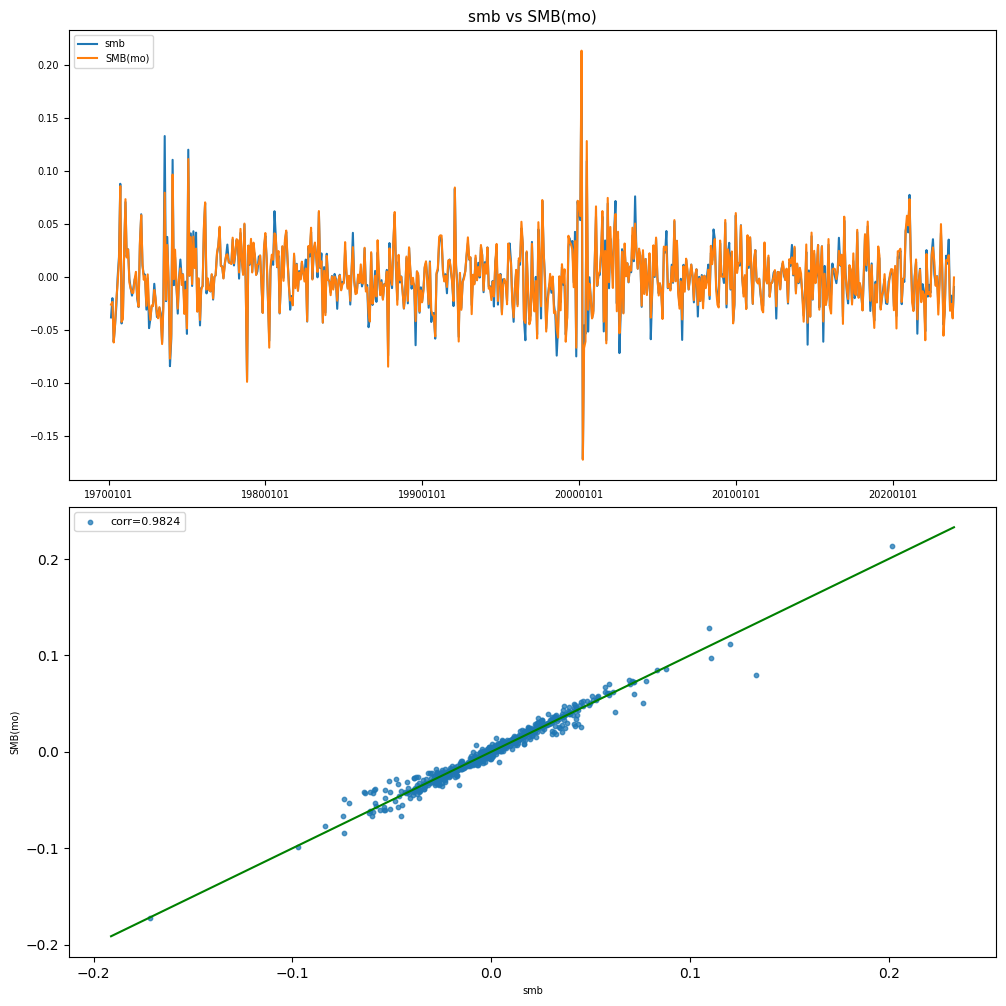

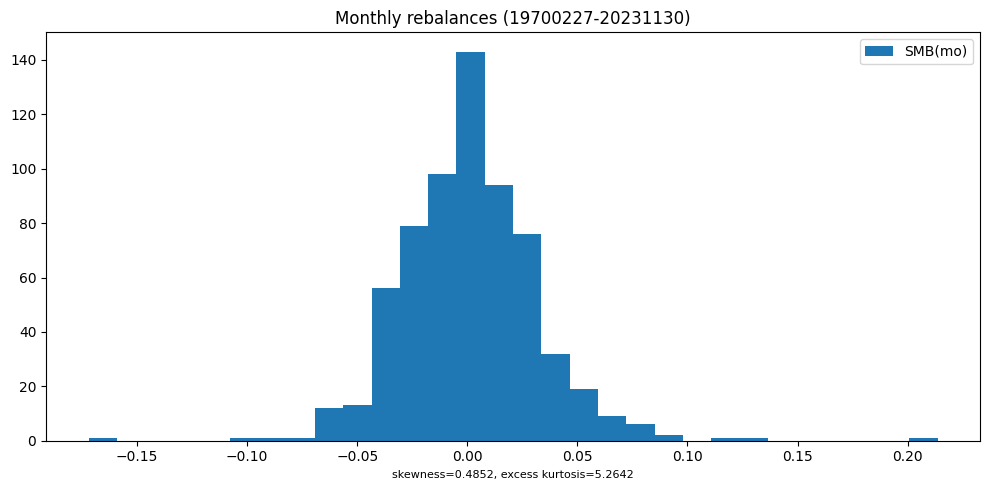

In [15]:
# Plot histogram and comparison of SMB returns
label, benchname = 'smb', 'SMB(mo)'
holdings = smb
result = backtest(monthly, holdings, label)
y = backtest.fit([benchname], rebalbeg, LAST_DATE)
plot_ff(y, label)
plot_summary(y, benchname)

## Linear regression



__Simple Linear Regression__

The simple linear regression (SLR) model relates a continuous
response (or dependent) variable $y_i$ with one predictor (or
explanatory or independent) variable $x_i$ and an
error term $\epsilon_i$: 

$$y_i = f(x_i) + \epsilon_i = a + b
x_i + \epsilon_i$$

Coefficent estimates of the slope $b$ and intercept $a$ are chosen to minimize the residual sum of squares: 

$$\hat{b} = \dfrac{\sum_{i=1}^{n} (x_i -
    \bar{x})(y_i - \hat{y})}{\sum_{i=1}^{n} (x_i - \bar{x})^2}$$


$$\hat{a} = \bar{y} - \hat{b} \bar{x}$$
  
- Residuals are the difference between the observed response values
  and the response values predicted by the model, $e_i = y_i -
  \hat{y}_i$.

- Residual sum of squares (RSS) over all observations is $RSS = e^2_1 +
  e^2_2 + ... + e^2_n$ or equivalently $RSS = \sum_{i=1}^n (y_i -
  \hat{y}_i)^2$.

- Mean square error (MSE) is an estimate of the variance of the
  residuals $s^2 = \hat{\sigma}^2 = \frac{1}{n-2} \sum_{i=1}^n (y_i -
  \hat{y}_i)^2$.

- Residual standard error (RSE) or residual standard deviation is
  the estimate of the (square root of the) variance of the residuals.
  Standard error tells us the average amount that the estimate differs
  from the actual value. The residual standard error is the estimate
  of the (square root of the) variance of the residuals $\hat{s}
  \equiv RSE = \sqrt{RSS/(n - 2)}$.



The estimators of the coefficients are normally distributed in large samples.Therefore, tests of a hypothesis about a regression parameter are implemented using a t-test. The standard errors associated with linear regression coefficient and mean response estimates are:
- Slope: $se(\hat{b}) = \sqrt{\dfrac{s^{2}}{\sum_{i=1}^{n}(x_{i} - \overline{x})^{2}}}$
- Intercept: $se(\hat{a}) = \sqrt{s^{2}[\dfrac{1}{n} + \dfrac{\overline{x}^{2}}{\sum_{i=1}^{n}(x_{i} - \overline{x})^{2}}]}$
- Mean response: $se(\hat{y}) = \sqrt{s^2 [\dfrac{1}{n} + \dfrac{(x -
      \bar{x})^2}{\sum_{i=1}^{n}(x_i - \bar{x})^2}]}$


- Confidence intervals can be computed from standard errors. A 95\% confidence interval is defined as a
  range of values such that with 95\% probability, the range will
  contain the true unknown value of the parameter.  The confidence
  interval for coefficient estimates is:\\ $b_j \pm t_{n - (k + 1), 1 -
    \frac{\alpha}{2}}\ se(b_j)$, where $k$, the number of regressors,
  equals 1 for SLR.

- Prediction interval for a new response is 
  $se(\hat{y}_{n+1}) = \sqrt{s^2 (1 + \dfrac{1}{n} + \dfrac{(x -
      \bar{x})^2}{\sum_{i=1}^{n}(x_i - \bar{x})^2})}$


__Multiple Linear Regression__

With multiple regressors, the linear model $y = b_0 + b_1 x_1 + ... +
b_k x_k + \epsilon$ has coefficient estimates:
$$\hat{b} = (X^T X)^{-1} X^T y$$

The coefficient $b_{j}$ quantifies the association between the
$j$ 'th predictor and the response. It is the average effect on Y of a
one unit increase in $X_j$, holding all other predictors fixed.

- Sum of squares total (SST) measures the total variance in the
  response Y, and can be thought of as the amount of variability
  inherent in the response before the regression is performed.
  $\mathrm{SST} = \sum_{i=1}^n (y_i - \overline{y})^2$ measures the total
  variance in the response Y.

- Sum of squares regression (SSR) measures the total amount 
  variance captured by the regression model:
  $\mathrm{SSR} = \sum{i=1}^n  (\hat{y}_i - \overline{y})^2$

- Sum of squares error (SSE) measures the total variance of the
  response not explained by the regression model.  In the linear
  regression context, we may intepret total deviation to equal the
  deviation not explained by the explanatory variables plus deviation
  explained by the explanatory variables: 
  $(y_i - \overline{y}) = (y_i - \hat{y}_i) + (\hat{y}_i - \overline{y}_i)$.  
  Squaring each side
  and summing over all observations yields for the total sum of
  squared deviations $SST = \sum_{i=1}^n (y_i - \hat{y}_i)^2 +
  \sum_{i=1}^n (\hat{y}_i - \overline{y}_i)^2 = SSE + SSR$, where the
  sum of the cross-product terms turns out to be zero.

- $R^2$ statistic or coefficient of determination measures the
  proportion of variability in Y that can be explained using X. It is
  also identical to the squared correlation between X and Y. An $R^2$
  statistic that is close to 1 indicates that a large proportion of
  the variability in the response has been explained by the
  regression. A number near 0 indicates that the regression did not
  explain much of the variability in the response.  The $R^2$
  statistic provides a relative measure of the quality of a linear
  regression fit $R^2 = 1 - \frac{\mathrm{RSS}}{\mathrm{SST}}$, and
  always takes on a value between 0 and 1, and is independent of the
  scale. $R^2$ is identical to the squared correlation between $X$ and
  $Y$.

- Adjusted $R^2$: The usual $R^2$ always increases (since residual
  sum of squares RSS always decreases) as more variables are
  added. The intuition behind the adjusted $R^2$ is that once all of
  the correct variables have been included in the model, adding noise
  variables will lead to a decrease in the statistic. In theory, the
  model with the largest adjusted $R^2$ will have only correct
  variables and no noise variables.


- Partial correlation coefficients, which measure the correlation between $y$ and the
  $j$ 'th explanatory variable $x_j$ controlling for other explanatory
  variables, can also be obtained by running only one regression:
  $$r(y, x_j |
  x_1,x_2,...,x_{j-1},x_{j+1},...,x_k) = \frac{t(b_j)}{\sqrt{t(b_j)^2
      + n - (k+1)}}$$
  where $t(b_j)$ is the t-ratio for $b_j$ from a
  regression of $y$ on $x_1,...,x_k$ (including the variable $x_j$).


- t-statistic or t-ratio: $t(b_j) = \dfrac{b_j}{se(b_j)}$ can be
  interpreted to be the number of standard errors that $b_j$ is away
  from zero. In a t-test, the null hypothesis ($H_0: \beta_j = 0$) is
  rejected in favor of the alternative if the absolute value of the
  t-ratio $|t(b_j)|$ exceeds a t-value, denoted $t_{n - (k + 1), 1 -
    \frac{\alpha}{2}}$, equal to the $(1 - \frac{\alpha}{2})$ 'th
  percentile from the t-distribution using $df = n - ( k + 1)$ degrees
  of freedom.



The t-test is not directly applicable when testing hypotheses that involve more than one parameter, because the parameter estimators can be correlated. Instead, a common alternative called the F-test compares the fit of the model (measured using the RSS) when the null hypothesis is true relative to the fit of the model without the restriction on the parameters assumed by the null. To test whether all regression slope coefficients are zero $H_0: b_1 = 
  ... = b_p = 0$, versus the
  alternative $H_a :$ at least one $b_j$ is non-zero, compute the statistic. which has a $F(p, n-p-1)$ distribution:

$$F = \dfrac{(TSS - RSS)/p}{RSS/(n - p - 1)}$$

  
Partial F-test: Sometimes, we want to test that a particular
  subset of $q$ of the coefficients are zero. In this case we fit a
  second model that uses all the variables except those last $q$, then
  compute residual sum of squares for that model and the appropriate
  F-statistic, which has a $F(p-q, n-p-1)$ distribution:
  
  $$F = \dfrac{(RSS_q - RSS)/(p - q)}{RSS/(n - p - 1)}$$
  

### Value effect

The value effect refers to the tendency of stocks with low price-to-book ratios (value stocks) to outperform stocks with high price-to-book ratios (growth stocks) over the long term.  The value investing approach, often associated with Benjamin Graham and David Dodd, emphasizes investing in stocks that are undervalued based on their intrinsic value, which is determined through fundamental analysis of a company's financials and business prospects.

In [16]:
# Linear regression on Mkt-Rf and intercept
x = ["HML(mo)", "Mkt-RF(mo)"]
formula = f'Q("{x[0]}") ~ ' + " + ".join(f'Q("{v}")' for v in x[1:])
data = bench.get_series(x, field='ret', beg=19620701, end=20991231)
lm = smf.ols(formula, data=data).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(f"Period: {data.index[0]}-{data.index[-1]}")
print(lm.summary())

Period: 19620731-20240430
                            OLS Regression Results                            
Dep. Variable:           Q("HML(mo)")   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     8.703
Date:                Sat, 29 Jun 2024   Prob (F-statistic):            0.00328
Time:                        09:53:49   Log-Likelihood:                 1570.5
No. Observations:                 742   AIC:                            -3137.
Df Residuals:                     740   BIC:                            -3128.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       

### Small firm effect

The small firm effect, also known as the size effect, was documented by Rolf Banz in 1981, showing that small-cap stocks tend to have higher risk-adjusted returns than large-cap stocks. 

In [17]:
# Linear regression on Mkt-Rf, HML and intercept
x = ["SMB(mo)", "HML(mo)", "Mkt-RF(mo)"]
formula = f'Q("{x[0]}") ~ ' + " + ".join(f'Q("{v}")' for v in x[1:])
data = bench.get_series(x, field='ret', beg=19620701, end=20991231)
lm = smf.ols(formula, data=data).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(f"Period: {data.index[0]}-{data.index[-1]}")
print(lm.summary())

Period: 19620731-20240430
                            OLS Regression Results                            
Dep. Variable:           Q("SMB(mo)")   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     28.04
Date:                Sat, 29 Jun 2024   Prob (F-statistic):           1.83e-12
Time:                        09:53:49   Log-Likelihood:                 1578.2
No. Observations:                 742   AIC:                            -3150.
Df Residuals:                     739   BIC:                            -3137.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       

## Structural break

The Chow F-test is normally used in the analysis of time series to
test the presence of a structural change.  We fit separate models
before and after a posited breakpoint -- in this case that the mean
returns to HML are different before and after its 1993 publication.
The null hypothesis of the Chow test is that estimated
coefficients of the two submodels are equal, which would be equal
a single restricted model estimated from the full data sample.

chow = $\dfrac{(RSS -
(RSS_1 + RSS_2))/K}{(RSS_1 + RSS_2) / (N - 2K)}$ follows a $F(K,
N-2K)$ distribution



In [18]:
# Run restricted and unregression models
#formula = f'Q("HML(mo)")~ '
bp = 19931231  # breakpoint date
lm1 = smf.ols(formula, data=data[data.index<=bp]).fit()
print(f'\nSub Model 1 ({data.index[0]}-{bp}):')
print(lm1.summary())
lm2 = smf.ols(formula, data=data[data.index>bp]).fit()
print(f'\nSub Model 2 ({bp}-{data.index[-1]}):')
print(lm2.summary())
lm0 = smf.ols(formula, data=data).fit()
print('\nRestricted Model (coefficient is equal):')
print(lm0.summary())


Sub Model 1 (19620731-19931231):
                            OLS Regression Results                            
Dep. Variable:           Q("SMB(mo)")   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     28.70
Date:                Sat, 29 Jun 2024   Prob (F-statistic):           2.52e-12
Time:                        09:53:49   Log-Likelihood:                 835.73
No. Observations:                 378   AIC:                            -1665.
Df Residuals:                     375   BIC:                            -1654.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercep

Test statistic with K parameters and N observations follows a $F(K, N-2K)$-distribution


In [19]:
# Compute test statistic
K = len(lm0.params)
N = len(data)
RSS = lm0.resid.dot(lm0.resid)
RSS1 = lm1.resid.dot(lm1.resid)
RSS2 = lm2.resid.dot(lm2.resid)
chow = ((RSS - (RSS1 + RSS2)) / K) / ((RSS1 + RSS2) / (N - 2*K))
chow, N, K

(3.5195180596913436, 742, 3)

p-value of Chow test statitic

In [20]:
1 - scipy.stats.f.cdf(chow, dfn=K, dfd=N - 2*K)

0.014824495307899976

5% critical value to reject null

In [21]:
scipy.stats.f.ppf(q=1 - 0.05, dfn=K, dfd=N - 2*K)

2.617002908894789